## Reference:
* Gonen, H.; and Goldberg, Y. 2019. Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases in Word Embeddings But do not Remove Them. NAACL-HLT.
* Yang, Z.; and Feng, J. 2020. A causal inference method for reducing gender bias in word embedding relations. In Proceedings of the AAAI Conference on Artificial Intelligence, volume 34, 9434–9441.
* Ding, L., Yu, D., Xie, J., Guo, W., Hu, S., Liu, M., Kong, L., Dai, H., Bao, Y. and Jiang, B., 2022, June. Word embeddings via causal inference: Gender bias reducing and semantic information preserving. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 36, No. 11, pp. 11864-11872).

In [1]:
import numpy as np
import pandas as pd
import scipy, requests, codecs, os, re, nltk, itertools, csv
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from scipy.stats import spearmanr
import functools as ft
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import gdown

## Read File

In [2]:
VEC_LEN = 300
glove_file = open("./Data/WordEmbedding/glove_wiki_vectors.txt", 'r')
glove_word = {}
for line in glove_file:
    line = line.strip()
    _word = line.split(' ')
    vector = np.array([float(num) for num in _word[1:]])
    if len(vector) != VEC_LEN: 
        raise Exception("Word dimension is wrong")
    glove_word[_word[0]] = vector
glove_file.close()
print(len(glove_word))

322636


In [3]:
df = pd.read_csv('Iter_1_q_75_9000_Glove.csv')

In [4]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
proj = np.identity(len(df)) - df

In [6]:
VEC_LEN = 300
debias_file = open("./Data/WordEmbedding/glove_wiki_vectors.txt", 'r')
debias_word = {}
for line in debias_file:
    line = line.strip()
    _word = line.split(' ')
    vector = np.array([float(num) for num in _word[1:]])
    if len(vector) != VEC_LEN: 
        raise Exception("Word dimension is wrong")
    debias_word[_word[0]] = np.array(proj @ vector) #load vector and do projection
debias_file.close()

## Word Similarity Test

In [7]:
'''
Read the male words and female words
'''
gender_specific = []
with open('./Data/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('./Data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

exclude_words = gender_specific
print(len(exclude_words))

446


In [8]:
'''
Generate word list for evaluation
'''
import string 
from tqdm import tqdm

def has_punct(w):
    '''
    Examine if the word includes punctuations
    Arg:
        w - str, word for examining
    Returns:
        bool
    '''
    if any([c in string.punctuation for c in w]):
        return True
    return False

def has_digit(w):
    '''
    Examine if the word includes numbers
    Arg:
        w - str, word for examining
    Returns:
        bool
    '''
    if any([c in '0123456789' for c in w]):
        return True
    return False

def limit_vocab(word_embedding, exclude = None, vec_len = 300):
    '''
    Generate the word list for evaluation
    Arg:
        word_embedding - dict{str:np.array}, the word vector dictionary
        exclude - list[str], the list of gender words
        vec_len - int, the number of dimentions of word vector
    Returns:
        vocab_limited - list[str], the evaluation word list
    '''
    vocab_limited = []
    for w in tqdm(list(word_embedding.keys())[:50000]): 
        if w.lower() != w:
            continue
        if len(w) >= 20:
            continue
        if has_digit(w):
            continue
        if '_' in w:
            p = [has_punct(subw) for subw in w.split('_')]
            if not any(p):
                vocab_limited.append(w)
            continue
        if has_punct(w):
            continue
        vocab_limited.append(w)
    
    if exclude:
        vocab_limited = list(set(vocab_limited) - set(exclude))
    
    print("size of vocabulary:", len(vocab_limited))
    
    return vocab_limited

word_limited = limit_vocab(glove_word, exclude_words)

100%|████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 231748.71it/s]

size of vocabulary: 47698


In [9]:
'''
Calculate Pearson correlation coeficient
'''
import scipy.stats

def pearson(a,b):
   
    return scipy.stats.pearsonr(a,b)

def compute_corr(tuples, i1, i2):
    '''
    Calculate Pearson correlation coeficient between two lists
    Args:
        tuples - list[list[int]], the elements are result of each test
        i1 - int, for each test, the index of number to form first list in Pearson
        i2 - int, for each test, the index of number to form second list in Pearson
                e.g. i1==2; i2==4 means we select second and forth numbers in the tests results to do Pearson test
    Returns:
        (float, float) - a tuple of (coeficient, p-value)
    '''
    
    a = []
    b = []
    for t in tuples:
        a.append(t[i1])
        b.append(t[i2])
    assert(len(a)==len(b))    
    return pearson(a,b)

In [10]:
dataSets = ['EN-RG-65.txt', 'EN-WS-353-ALL.txt', 'EN-RW-STANFORD.txt', 'EN-MEN-TR-3k.txt', 'EN-MTurk-287.txt', 'EN-MTurk-771.txt', 'EN-SIMLEX-999.txt', 'EN-SimVerb-3500.txt']


def similarity_eval(dataSetAddress, wordVecModel_str):
    
    wordVecModel = eval(wordVecModel_str)
    vocab = set(list(wordVecModel.keys()))
    
    fread_simlex = open(dataSetAddress, "r")
    
    pair_list = []

    line_number = 0
    for line in fread_simlex:

        tokens = line.split()
        word_i = tokens[0]
        word_j = tokens[1]
        score = float(tokens[2])
        if word_i in vocab and word_j in vocab:
            pair_list.append( ((word_i, word_j), score) )

    pair_list.sort(key=lambda x: - x[1]) # order the pairs from highest score (most similar) to lowest score (least similar)


    extracted_scores = {}

    extracted_list = []
    
               
    for (x,y) in pair_list:
        (word_i, word_j) = x
        
        current_distance = 1- cosine_similarity( wordVecModel[word_i].reshape(1,-1)  , wordVecModel[word_j].reshape(1,-1) )        

        extracted_scores[(word_i, word_j)] = current_distance
        extracted_list.append(((word_i, word_j), current_distance))

    extracted_list.sort(key=lambda x: x[1])

    spearman_original_list = []
    spearman_target_list = []

    for position_1, (word_pair, score_1) in enumerate(pair_list):
        score_2 = extracted_scores[word_pair]
        position_2 = extracted_list.index((word_pair, score_2))
        spearman_original_list.append(position_1)
        spearman_target_list.append(position_2)

    spearman_rho = spearmanr(spearman_original_list, spearman_target_list)
    
    return spearman_rho[0]

In [11]:
print('Word Similarity task\nGood result is higher\n')
resourceFile = './Data/' 

for dataset in dataSets:
    dataSetAddress = resourceFile + 'WordSim/' +  dataset
    print(dataset)
    print('%.4f' %  similarity_eval(dataSetAddress, 'debias_word'))

Word Similarity task
Good result is higher

EN-RG-65.txt
0.7913
EN-WS-353-ALL.txt
0.6617
EN-RW-STANFORD.txt
0.3986
EN-MEN-TR-3k.txt
0.7423
EN-MTurk-287.txt
0.6349
EN-MTurk-771.txt
0.6792
EN-SIMLEX-999.txt
0.3949
EN-SimVerb-3500.txt
0.2493


# GBWR

In [12]:
'''
Normalize the word embedding
'''
def normalize(word_embedding):
    for word in word_embedding.keys():
        vec = word_embedding[word]
        norm = np.linalg.norm(vec)
        word_embedding[word] = vec / norm

def check_normalize(word_embedding):
    count = 0
    for word in word_embedding.keys():
        vec = word_embedding[word]
        if np.linalg.norm(vec) > 1.0001 or np.linalg.norm(vec) < 0.9999:
            print(word)
            print(count)
            raise Exception("Normalize error")
            
def dim299(word_embedding):
    for w in word_embedding:
        try:
            word_embedding[w] = word_embedding[w][:-1]
            assert(len(word_embedding[w]) == 299)
        except Exception:
            print(w)

normalize(glove_word)
check_normalize(glove_word)
print("Done")
debias_copy = debias_word.copy()
normalize(debias_word)
check_normalize(debias_word)
print("Done")

Done
Done


## WEAT Test

In [13]:
import scipy
import scipy.misc as misc
import itertools
from tqdm import tqdm
import random

def similarity(w1, w2):
    
    return w1.dot(w2)

def s_word(w, A, B, word_embedding, all_s_words):
    '''
    Calculate association s(w, A, B) in WEAT test
    Args:
        w - str, the word for calculate
        A - list[str], attribute set 1
        B - list[str], attribute set 2
        word_embedding - dict{str:np.array}, {word:vector} word vectors dictionary
        all_s_words - dict{str:float}, {word:value of s(w, A, B)} record the result of the word
    Returns:
        float - value of s(w, A, B)
    '''
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(similarity(word_embedding[w], word_embedding[a]))
    for b in B:
        mean_b.append(similarity(word_embedding[w], word_embedding[b]))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, word_embedding, all_s_words):
    '''
    Calculate test statistic s(X, Y, A, B) in WEAT test
    Args:
        X - list[str], target set 1
        Y - list[str], target set 2
        A - list[str], attribute set 1
        B - list[str], attribute set 2
        word_embedding - dict{str:np.array}, {word:vector} word vectors dictionary
        all_s_words - dict{str:float}, {word:value of s(w, A, B)} record the result of each word
    Returns:
        float - value of s(X, Y, A, B)
    '''
    total = 0
    for x in X:
        total += s_word(x, A, B, word_embedding, all_s_words)
    for y in Y:
        total -= s_word(y, A, B, word_embedding, all_s_words)
        
    return total

def effect_size(X, Y, A, B, word_embedding, all_s_words):
    '''
    Calculate effect size d in WEAT test
    Args:
        X - list[str], target set 1
        Y - list[str], target set 2
        A - list[str], attribute set 1
        B - list[str], attribute set 2
        word_embedding - dict{str:np.array}, {word:vector} word vectors dictionary
        all_s_words - dict{str:float}, {word:value of s(w, A, B)} record the result of each word
    Returns:
        float - effect size d
    '''
    total_x = []
    total_y = []
    
    for x in X:
        total_x.append(s_word(x, A, B, word_embedding, all_s_words))
    for y in Y:
        total_y.append(s_word(y, A, B, word_embedding, all_s_words))
        
    
    mean = sum(total_x)/float(len(total_x)) - sum(total_y)/float(len(total_y))
    std_dev = np.std(total_x + total_y)
    
    if std_dev == 0:
        print("Error! ")
    
    return mean / std_dev


def p_value_exhust(X, Y, A, B, word_embedding):
    '''
    WEAT test
    Args:
        X - list[str], target set 1
        Y - list[str], target set 2
        A - list[str], attribute set 1
        B - list[str], attribute set 2
        word_embedding - dict{str:np.array}, {word:vector} word vectors dictionary
    Returns:
        tuple(float, float) - (test statistic, effect size)
    '''
    

    if len(X) > 10:
        print('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, word_embedding, all_s_words) 
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0

    for subset in set(itertools.combinations(union, subset_size)):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, word_embedding, all_s_words) > s_orig:
            larger += 1
    
    d = effect_size(X, Y, A, B, word_embedding, all_s_words)
    
    return larger/float(total), d

In [14]:
def weat_test(word_embedding):
    final = "Experiment 1 : "

    A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
    B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']
    C = ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation']
    D = ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy', 'divorce', 'jail', 'poverty', 'ugly', 'cancer', 'kill', 'rotten', 'vomit', 'agony', 'prison']
    
    result = p_value_exhust(A, B, C, D, word_embedding)
    final += "p-value: " + str(result[0]) + "\t effect size: " + str(result[1]) + '\n'

    final += "Experiment 2 : "

    E = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
    F = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

    result = p_value_exhust(A, B, E, F, word_embedding)
    final += "p-value: " + str(result[0]) + "\t effect size: " + str(result[1]) + '\n'


    final +=  "Experiment 3 : "

    G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
    H = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

    
    result = p_value_exhust(A, B, G, H, word_embedding)
    final += "p-value: " + str(result[0]) + "\t effect size: " + str(result[1]) + '\n'
    

    return final

In [15]:
print(weat_test(debias_word))

Experiment 1 : p-value: 0.41126651126651126	 effect size: 0.11905717812383561
Experiment 2 : p-value: 0.14172494172494174	 effect size: 0.5645880559728366
Experiment 3 : p-value: 0.9123543123543123	 effect size: -0.7106859549232489



## Gender-projection

In [16]:
# create a dictionary of the bias, before and after

def compute_bias_by_projection(word_embedding, word_list):
    '''
    Calculate gender projection on gender direction for each word
    Args:
        word_embedding - dict{str:np.array}, {word:vector} word vectors dictionary
        word_list - list[str], the evaluation word list
    Returns:
        dict{str:float} - {word:projection}, record the projection of each word in the evaluation word list
    '''
    direction = word_embedding['he'] - word_embedding['she']
    d = {}
    for w in word_list:
        try:
            d[w] = word_embedding[w].dot(direction)
        except Exception:
            print(w)
            continue
    return d
word_project = compute_bias_by_projection(glove_word, word_limited)
debias_project = compute_bias_by_projection(debias_word, word_limited)

dim299(debias_copy)
normalize(debias_copy)
check_normalize(debias_copy)
del debias_word
debias_word = debias_copy



# calculate the avg bias of the vocabulary (abs) before and after debiasing

def report_bias(gender_bias):
    '''
    Calculate average word projection in the evaluation word list
    Args:
        gender_bias - dict{str:float}, {word:projection} dictionary records projection of word
    Returns:
        float - average gender projection
    '''
    bias = 0.0
    for k in gender_bias:
        bias += np.abs(gender_bias[k])
    return bias/len(gender_bias)



In [17]:
print("debias word : {}\n".format(report_bias(debias_project)))

debias word : 0.01163070007161296



## Correlation between bias-by-projection and bias-by-neighbors

In [23]:
def word_vec(word_embedding, word_list):
    '''
    Integrete the word vectors in the evaluation word list in a matrix.
    Args:
        word_embedding - dict{str:np.array}, {word:vector} word vectors dictionary
        word_list - list[str], the evaluation word list
    Returns:
        np.array(number of words, number of dimentions) - each row is a word vector, the order is same as the word list
    '''
    word_limited_vec = []
    for w in word_list:
        try:
            word_limited_vec.append(word_embedding[w])
        except:
            print(w)
            continue
    word_limited_vec = np.array(word_limited_vec)
    return word_limited_vec

word_limited_vec = word_vec(glove_word, word_limited)
debias_limited_vec = word_vec(debias_word, word_limited)


In [24]:
# get tuples of biases and counts of masculine/feminine NN for each word (for bias-by-neighbors)

def bias_by_neighbors(word_embedding, word_list, word_limited_vec, gender_bias_project, neighbours_num = 105):
    '''
    Calculate the gender-biased words in the k nearest neighbors of each word in the word list
    Args:
        word_embedding - dict{str:np.array}, {word:vector} word vectors dictionary
        word_list - list[str], the evaluation word list
        word_limited_vec - np.array(number of words, number of dimentions),
                            each row is a word vector, the order is same as the word list
        gender_bias_project - dict{str:float}, {word:projection} record the projection of each word in the evaluation word list
        neighbours_num - int, select top k similar neighbors
    Returns:
        tuple(str, np.array, int) - (word, word vector, the number of male words in top k similar neighbors)
    '''
    tuples = []
    count = 0
    for w in tqdm(word_list):
        
        vec = word_embedding[w]
        sim = word_limited_vec.dot(vec)
        sort_sim = (sim.argsort())[::-1]
        best = sort_sim[:(neighbours_num+1)]
        
        top = []
        for i in best:
            if i != count:
                top.append(word_list[i])
            elif word_list[i] != word_list[count]:
                raise Exception("Same Word Error")
        

        m = 0
        f = 0    
        for t in top[:100]:
            if gender_bias_project[t] > 0:
                m+=1
            else:
                f+=1
            
        tuples.append((w, word_project[w], m))
        count = count + 1

    return tuples

tuples_debias = bias_by_neighbors(debias_word, word_limited, debias_limited_vec, word_project) 

100%|████████████████████████████████████████████████████████████████████████████████████████████| 47698/47698 [11:28<00:00, 69.27it/s]


In [25]:
print("GBWR correlation task :\nk-nearest neighbor of 50000 words, percent of male in k = 100\nGood result is lower")

print("debias word : \n{}\n".format(compute_corr(tuples_debias, 1, 2)))

GBWR correlation task :
k-nearest neighbor of 50000 words, percent of male in k = 100
Good result is lower
debias word : 
(0.5198836982434382, 0.0)



## Clustering Experiment

In [ ]:
X_bef, X_aft = extract_vectors(male + female, glove_word, debias_word)
y_pred_bef = KMeans(n_clusters=2, random_state=1).fit_predict(X_bef)
X_embedded_bef = TSNE(n_components=2).fit_transform(X_bef)
y_pred_aft = KMeans(n_clusters=2, random_state=1).fit_predict(X_aft)
X_embedded_aft = TSNE(n_components=2).fit_transform(X_aft)

No handles with labels found to put in legend.


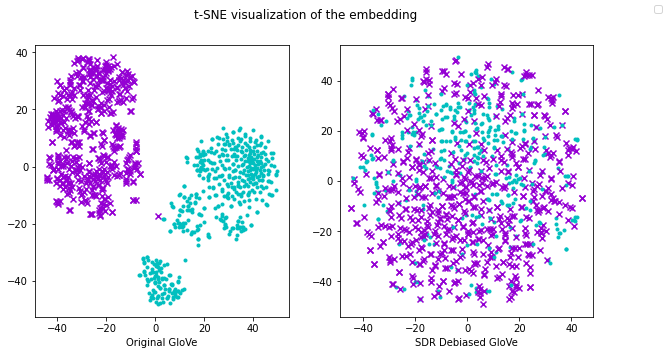

In [83]:
fig, axes = plt.subplots(ncols=2,figsize=(10, 5))

for x,l in zip(X_embedded_bef, y_pred_bef):
    if l:
        axes[0].scatter(x[0], x[1], marker = '.', c = 'c')
        #plt.scatter(x[0], x[1], marker = '.', c = 'c',)
    else:
        axes[0].scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
        #plt.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')

axes[0].set(xlabel='Original GloVe')
#axes[0].set_title('Original GloVe',y=-0.05)

for x,l in zip(X_embedded_aft, y_pred_aft):
    if l:
        axes[1].scatter(x[0], x[1], marker = '.', c = 'c')
        #plt.scatter(x[0], x[1], marker = '.', c = 'c',)
    else:
        axes[1].scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
        #plt.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')

axes[1].set(xlabel='SDR Debiased GloVe')
fig.legend()
fig.suptitle('t-SNE visualization of the embedding')
fig.savefig('tsne.jpg')

In [26]:
# Auxiliary finctions

import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import operator
import random

from sklearn.cluster import KMeans

from sklearn.manifold import TSNE


def visualize(vectors, words, labels, title, ax, num_clusters = 2):
    
    # perform TSNE
    
    
    #plt.figure()
    X_embedded = TSNE(n_components=2).fit_transform(vectors)
    if num_clusters == 2:
        for x,l,i in zip(X_embedded, labels, [0,1]):
            if l:
                ax.scatter(x[0], x[1], marker = '.', c = 'c',)
                #plt.scatter(x[0], x[1], marker = '.', c = 'c',)
            else:
                ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
                #plt.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    else:
        pass
        #plt.scatter(X_embedded[:,0], X_embedded[:,1], c = labels)                

    # ax.text(.01, .9, title ,transform=ax.transAxes, fontsize=18)
    #plt.show()


def extract_vectors(words, before, after):
    '''
    Generate the word vector set
    '''
    size = len(words)/2
    
    X_bef = []
    X_aft = []
    for x in words:
        if x in after:
            X_bef.append(before[x])
            X_aft.append(after[x])
        else:
            print(x)
#     X_bef = [before[x] for x in words]
#     X_aft = [after[x] for x in words]
        
    X_bef = pd.DataFrame(X_bef)
    X_aft = pd.DataFrame(X_aft)
    
    return X_bef, X_aft

    

def cluster(words, X_bef, X_aft, random_state, y_true, num=2):
    '''
    Use K-Means to cluster the word vector set and calcualte the accuracy
    Args:
        words - list[str], the word list for clustering
        X_bef - list[np.array], the list of the original word vectors
        X_aft - list[np.array], the list of the debiased word vectors
        random_state - int
        y_true - list[int], the label (female/male) of the words
        num - int, the number of clusters
    Return:
        str - the accuracy of clustering test
    '''
    final = ''
    
    import pdb
#    pdb.set_trace()
    y_pred_bef = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_bef)
    #visualize(X_bef, words, y_pred_bef, 'Original',axes[0])
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_bef) ]
    final += "original glove: {} ".format(sum(correct)/float(len(correct)))
    
    y_pred_aft = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_aft)
    for i in range(0, len(y_pred_aft)):
        if y_pred_aft[i] == 0:
            y_pred_aft[i] = 1
        else:
            y_pred_aft[i] = 0
        
    #visualize(X_aft, words, y_pred_aft, 'Debiased',axes[1])
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_aft) ]
    accuracy = sum(correct)/float(len(correct))
    # print(accuracy)
    if accuracy < 0.5:
        accuracy = 1 - accuracy
    final += "compare with {} ".format(accuracy)
    
    return final, accuracy


# Cluster most biased words before and after debiasing
def test(before, after):
    '''
    Generate word vector set and label set
    Args:
        before - dict{word:np.array}, the original word embedding
        after - dict{word:np.array}, the debiased word embedding
    Returns:
        float - the accuracy of clustering test
    '''
    X_bef, X_aft = extract_vectors(male + female, before, after)
    
    
    y_true = [0]*size + [1]*size
    return cluster(male + female, X_bef, X_aft, random_state, y_true) 
    
random.seed(1)
random_state = 1

size = 500
sorted_g = sorted(word_project.items(), key=operator.itemgetter(1))
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]

GBWR clustering task : 
clustering top 500, show which word is clustered wrongly
Good result is lower
original glove: 1.0 compare with 0.536 debias word



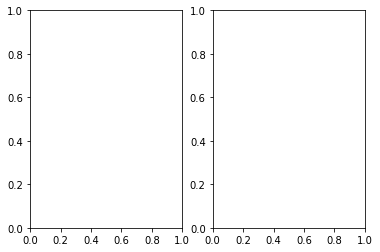

In [27]:
print("GBWR clustering task : ")
print("clustering top 500, show which word is clustered wrongly")
print("Good result is lower")
print("{}debias word\n".format(test(glove_word, debias_word)[0]))
#Xembed1, Xembed2 = test(glove_word, debias_word)

## Professional test

In [28]:
import json 

def extract_professions():
    '''
    Read the professions list
    Returns:
        list[str] - the list of professions
    '''
    professions = []
    with codecs.open('./Data/professions.json', 'r', 'utf-8') as f:
        professions_data = json.load(f)
    for item in professions_data:
        professions.append(item[0].strip())
    return professions


professions = extract_professions()

In [29]:
def get_tuples_prof(word_embedding, words, word_list, word_limited_vec, gender_bias_dict):
    '''
    Calculate the gender-biased words in the k nearest neighbors for each profession
    Args:
        word_embedding - dict{str:np.array}, {word:vector} word vectors dictionary
        words - list[str], the profession list
        word_list - list[str], the evaluation word list
        word_limited_vec - np.array(number of words, number of dimentions),
                            each row is a word vector, the order is same as the word list
        gender_bias_dict - dict{str:float}, {word:projection} record the projection of each word in the evaluation word list
    Returns:
        tuple(str, np.array, int) - (word, word vector, the number of male words in top k similar neighbors)
    '''
    
    
    tuples = []
    
    for w in words:
        if w not in gender_bias_dict:
            continue
            
        # top = topK(w, space, k=105)[:100]
        vec = word_embedding[w]
        sim = word_limited_vec.dot(vec)
        sort_sim = (sim.argsort())[::-1]
        best = sort_sim[:(105+1)]
        
        # if w in words:
        #     print(w)
        # idx = word_list.index(w)
        top = []
        for i in best:
            if word_list[i] != w:
                top.append(word_list[i])
            # else:
                # print("___________________")
                # print(w)
                # raise Exception("Same Word Error")
            
        m = 0
        f = 0  
        for t in top[:100]:          
            if gender_bias_dict[t] > 0:
                m+=1
            else:
                f+=1
                
        tuples.append((w, gender_bias_dict[w], m))
        
        
    return tuples

prof_glove = get_tuples_prof(glove_word, professions, word_limited, word_limited_vec, word_project)
prof_debias = get_tuples_prof(debias_word, professions, word_limited, debias_limited_vec, word_project)


In [30]:
print("GBWR professional task : \nk-nearest neighbor of professional words, percent of male in k = 100\nGood result is lower\n")
print("debias word : \n{}\n".format(compute_corr(prof_debias, 1, 2)[0]))

GBWR professional task : 
k-nearest neighbor of professional words, percent of male in k = 100
Good result is lower

debias word : 
0.6515575823395002



## Classification test

In [31]:
from sklearn import svm
from random import shuffle
import random
random.seed(100)



def train_and_predict(word_embedding):
    '''
    Train an SVM classifier and calculate the accuracy of prediction
    Args:
        word_embedding - dict{str:np.array}, {word:vector} word vectors dictionary
    Returns:
        float - the accuracy of prediction
    '''
    X_train = [word_embedding[w] for w in males[:size_train]+females[:size_train]]
    Y_train = [1]*size_train + [0]*size_train
    X_test = [word_embedding[w] for w in males[size_train:]+females[size_train:]]
    Y_test = [1]*size_test + [0]*size_test

    clf = svm.SVC()
    clf.fit(X_train, Y_train)

    preds = clf.predict(X_test)

    accuracy = [1 if y==z else 0 for y,z in zip(preds, Y_test)]
    return float(sum(accuracy))/len(accuracy)

    
# extract most biased words
size_train = 500
size_test = 2000
size = size_train + size_test
sorted_g = sorted(word_project.items(), key=operator.itemgetter(1))
females = [item[0] for item in sorted_g[:size]]
females = [w for w in females if w in word_limited]
males = [item[0] for item in sorted_g[-size:]]
males = [w for w in males if w in word_limited]
for f in females:
    assert(word_project[f] < 0)
for m in males:
    assert(word_project[m] > 0)
shuffle(females)
shuffle(males)

In [32]:
print("GBWR classification task : \ntop 25000 female and male, SVM is trained by 10000 words and predict other 40000\nGood result is lower\n")

print('debias word : {}\n'.format(train_and_predict(debias_word)))

GBWR classification task : 
top 25000 female and male, SVM is trained by 10000 words and predict other 40000
Good result is lower

debias word : 0.72475

